In [10]:
import pandas as pd 
import numpy as np
from collections import Counter
import gzip
import os
import subprocess

import matplotlib.pyplot as plt 
%matplotlib inline 
import seaborn as sns 
import subprocess

output_dir = '../output/fithic/combined'

## Loading chromosome sizes

In [24]:
# Loading chromosome sizes 
chromsize_fn = '/gpfs/data01/glasslab/home/joreyna/projects/CSE283/imarge_project//ref/chromsize.hg38.txt'
chromsizes = pd.read_table(chromsize_fn, sep='\t', names=['chrom', 'size'])
chromsizes.set_index('chrom', inplace=True)

# Excluding non-human chromosomes 
chroms = list(range(1, 23)) + ['X', 'Y']
chroms = ['chr{}'.format(x) for x in chroms]
chromsizes = chromsizes[chromsizes.index.isin(chroms)]

In [52]:
chromsizes.head()

,size
chrom,
chr1,248956422
chr2,242193529
chr3,198295559
chr4,190214555
chr5,181538259


## Analyzing bin counts 

I want to look at the chromosomal pairs and see if if there is a pair worth plotting somehow. 

#### HEK

In [142]:
def analyze_chrom_counts(sig_ints):
    
    chrom_counts = sig_ints.groupby(['chr1', 'chr2']).apply(len).to_frame().reset_index()
    norm_counts = []
    for i, sr in chrom_counts.iterrows():
        chrA_size = chromsizes.loc[sr['chr1'], 'size']
        chrB_size = chromsizes.loc[sr['chr2'], 'size']
        norm_count = sr[0] / (chrA_size * chrB_size / 1000000**2)
        #norm_count = - np.log10(norm_count)
        norm_counts.append(norm_count)
    chrom_counts['norm_counts'] = norm_counts
    
    return(chrom_counts)



In [143]:
cell_type = 'hek'
data_dir = '../output/fithic/{}'.format(cell_type)
sig_ints = os.path.join(data_dir, 'FitHiC.spline_pass1.res40000.significances.txt.flt.gz')
sig_ints = pd.read_table(sig_ints)
chrom_counts_hek = analyze_chrom_counts(sig_ints)
chrom_counts_hek.head()

,chr1,chr2,0,norm_counts
0,chr1,chr1,10182,0.164281
1,chr1,chr10,1977,0.059352
2,chr1,chr11,2178,0.064762
3,chr1,chr12,1977,0.059585
4,chr1,chr13,1270,0.044606


In [144]:
chrom_counts_hek.norm_counts.describe()

count    530.000000
mean       0.061751
std        0.084521
min        0.000112
25%        0.016796
50%        0.028159
75%        0.062298
max        1.007932
Name: norm_counts, dtype: float64

In [152]:
chrom_matrix_hek = chrom_counts_hek.pivot(index='chr1', columns='chr2', values='norm_counts')
chrom_matrix_hek = chrom_matrix_hek.loc[chroms, chroms]

/gpfs/data01/glasslab/home/joreyna/.conda/envs/tf_binding_nnet/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  


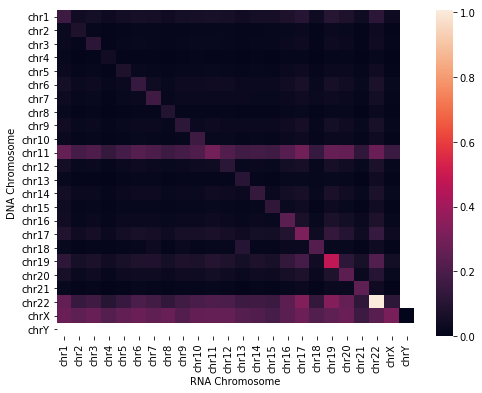

In [153]:
fig, ax = plt.subplots(figsize=(8,6))

sns.heatmap(chrom_matrix_hek, ax=ax)

ax.set_xlabel('RNA Chromosome')
ax.set_ylabel('DNA Chromosome');

### HFF

In [154]:
cell_type = 'hff'
data_dir = '../output/fithic/{}'.format(cell_type)
sig_ints = os.path.join(data_dir, 'FitHiC.spline_pass1.res40000.significances.txt.flt.gz')
sig_ints = pd.read_table(sig_ints)
chrom_counts_hff = analyze_chrom_counts(sig_ints)
chrom_counts_hff.head()

,chr1,chr2,0,norm_counts
0,chr1,chr1,4857,0.078365
1,chr1,chr10,1366,0.041009
2,chr1,chr11,1418,0.042164
3,chr1,chr12,1534,0.046233
4,chr1,chr13,856,0.030065


In [155]:
chrom_counts_hff.norm_counts.describe()

count    573.000000
mean       0.031746
std        0.051924
min        0.000184
25%        0.006833
50%        0.014153
75%        0.037094
max        0.349072
Name: norm_counts, dtype: float64

In [156]:
chrom_matrix_hff = chrom_counts_hff.pivot(index='chr1', columns='chr2', values='norm_counts')
chrom_matrix_hff = chrom_matrix_hff.loc[chroms, chroms]

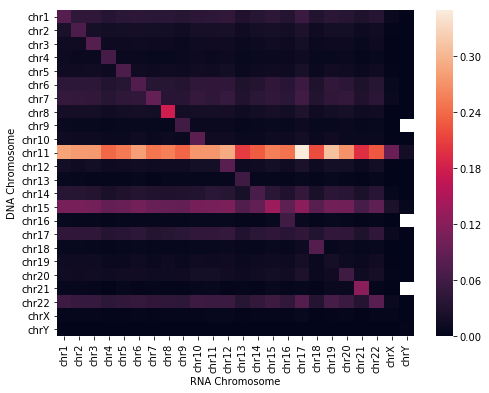

In [157]:
fig, ax = plt.subplots(figsize=(8,6))

sns.heatmap(chrom_matrix_hff, ax=ax)

ax.set_xlabel('RNA Chromosome')
ax.set_ylabel('DNA Chromosome');